In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import textwrap
import os, math, re

Auxiliary functions

In [49]:
def fairness_value(route_times, measure):
    rt = np.array(route_times, dtype=float)
    m = len(rt)
    if m == 0:
        return 0.0
    if measure.lower().startswith("jain"):
        s = rt.sum()
        denom = m * np.sum(rt**2)
        return 0.0 if denom == 0 else (s**2)/denom
    if measure.lower().startswith("max"):
        mx = rt.max()
        mn = rt.min()
        return 0.0 if mx <= 0 else mn/mx
    if measure.lower().startswith("gini"):
        s = rt.sum()
        if s <= 0:
            return 0.0
        num = np.sum(np.abs(rt.reshape(-1,1)-rt.reshape(1,-1)))
        denom = 2*m*s
        g = 1 - num/denom
        return float(np.clip(g,0,1))
    raise ValueError(measure)

def plot_fairness_box(data, title):
    labels = list(data.keys())
    values = [data[k] for k in labels]

    plt.figure(figsize=(7, 4))

    plt.boxplot(values, tick_labels=labels, showfliers=True)

    # overlay instance points
    for i, k in enumerate(labels, start=1):
        ys = data[k]
        xs = [i + (j - 1.5) * 0.05 for j in range(len(ys))]
        plt.scatter(xs, ys)

    plt.ylabel("Objective value")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_subplot(ax, data, title):
    labels = list(data.keys())
    values = [data[k] for k in labels]

    ax.boxplot(values, tick_labels=labels, showfliers=True)

    # overlay instance points
    for i, k in enumerate(labels, start=1):
        ys = data[k]
        xs = [i + (j - 1.5) * 0.05 for j in range(len(ys))]
        ax.scatter(xs, ys)

    ax.set_title(title)
    ax.set_ylabel("Objective value")

# ACO

In [50]:
data_aco = []

# Data transcribed from user's LaTeX table (seed=1)
# Format: (n, instance, fairness, obj, route_times, stops)
rows_aco = [
    (50, "instance31_nreq50_gamma50", "Jain", 2531.78, [1864, 663], [80,20]),
    (50, "instance31_nreq50_gamma50", "Max-min", 2543.71, [1864, 663], [80,20]),
    (50, "instance31_nreq50_gamma50", "Gini", 2533.16, [1864, 663], [80,20]),

    (50, "instance32_nreq50_gamma45", "Jain", 2020.37, [1336, 681], [56,34]),
    (50, "instance32_nreq50_gamma45", "Max-min", 2020.81, [951, 1066], [40,50]),
    (50, "instance32_nreq50_gamma45", "Gini", 2052.30, [1331, 716], [54,36]),

    (50, "instance33_nreq50_gamma45", "Jain", 2151.89, [779, 1370], [36,54]),
    (50, "instance33_nreq50_gamma45", "Max-min", 2167.75, [984, 1177], [38,52]),
    (50, "instance33_nreq50_gamma45", "Gini", 2182.84, [1188, 993], [48,42]),

    (50, "instance34_nreq50_gamma47", "Jain", 2486.71, [1789, 686], [68,26]),
    (50, "instance34_nreq50_gamma47", "Max-min", 2473.06, [1237, 1236], [48,46]),
    (50, "instance34_nreq50_gamma47", "Gini", 2490.75, [1789, 686], [68,26]),

    (100, "instance31_nreq100_gamma86", "Jain", 5359.33, [1753, 3598], [64,108]),
    (100, "instance31_nreq100_gamma86", "Max-min", 5423.66, [2682, 2740], [84,88]),
    (100, "instance31_nreq100_gamma86", "Gini", 5364.51, [1753, 3598], [64,108]),

    (100, "instance36_nreq100_gamma90", "Jain", 5661.51, [314, 5325], [12,168]),
    (100, "instance36_nreq100_gamma90", "Max-min", 5703.22, [4030, 1643], [120,60]),
    (100, "instance36_nreq100_gamma90", "Gini", 5661.67, [314, 5325], [12,168]),

    (100, "instance41_nreq100_gamma86", "Jain", 4768.07, [2478, 2290], [90,82]),
    (100, "instance41_nreq100_gamma86", "Max-min", 4769.19, [1631, 3117], [72,100]),
    (100, "instance41_nreq100_gamma86", "Gini", 4734.17, [2242, 2491], [84,88]),

    (100, "instance46_nreq100_gamma92", "Jain", 5899.07, [2810, 3089], [82,102]),
    (100, "instance46_nreq100_gamma92", "Max-min", 5929.88, [2925, 3004], [80,104]),
    (100, "instance46_nreq100_gamma92", "Gini", 5900.38, [3193, 2706], [104,80]),

    (200, "instance31_nreq200_gamma192", "Jain", 18342.61, [1181, 3488, 6877, 6738], [36,88,126,134]),
    (200, "instance31_nreq200_gamma192", "Max-min", 18764.59, [0, 0, 18490, 0], [0,0,384,0]),
    (200, "instance31_nreq200_gamma192", "Gini", 18205.81, [6554, 5274, 4654, 1666], [116,106,114,48]),

    (200, "instance36_nreq200_gamma181", "Jain", 15661.70, [4737, 3619, 2956, 4339], [104,92,78,88]),
    (200, "instance36_nreq200_gamma181", "Max-min", 16499.53, [0, 16137, 0, 0], [0,362,0,0]),
    (200, "instance36_nreq200_gamma181", "Gini", 15718.67, [5581, 947, 4374, 4734], [126,36,86,114]),

    (200, "instance41_nreq200_gamma196", "Jain", 17953.22, [3954, 5681, 4575, 3734], [82,132,88,90]),
    (200, "instance41_nreq200_gamma196", "Max-min", 18873.23, [0, 0, 0, 18539], [0,0,0,392]),
    (200, "instance41_nreq200_gamma196", "Gini", 18053.55, [3548, 6074, 3095, 5287], [78,118,80,116]),

    (200, "instance46_nreq200_gamma178", "Jain", 15210.94, [5250, 3601, 2874, 3458], [124,72,84,76]),
    (200, "instance46_nreq200_gamma178", "Max-min", 16125.64, [0, 0, 0, 15581], [0,0,0,356]),
    (200, "instance46_nreq200_gamma178", "Gini", 15274.49, [1210, 4722, 5385, 3837], [36,86,130,104]),

    (500, "instance31_nreq500_gamma465", "Jain", 59579.51, [5676, 10388, 4872, 1862, 5566, 6291, 6381, 7231, 4558, 6547], [92, 126, 82, 38, 86, 108, 94, 124, 86, 94]),
    (500, "instance31_nreq500_gamma465", "Max-min", 65679.02, [0, 0, 46512, 0, 0, 17219, 0, 0, 0, 0], [0, 0, 552, 0, 0, 378, 0, 0, 0, 0]),
    (500, "instance31_nreq500_gamma465", "Gini", 59506.65, [6274, 4809, 6393, 6587, 2636, 6159, 6825, 4278, 6234, 9032], [94, 78, 92, 110, 62, 94, 102, 78, 102, 118]),

    (500, "instance36_nreq500_gamma472", "Jain", 58605.78, [6197, 3438, 5100, 11190, 3553, 2402, 2587, 4968, 9259, 9421], [100, 72, 90, 148, 66, 52, 50, 94, 134, 138]),
    (500, "instance36_nreq500_gamma472", "Max-min", 65486.10, [0, 0, 51136, 11975, 0, 0, 0, 0, 0, 0], [0, 0, 708, 236, 0, 0, 0, 0, 0, 0]),
    (500, "instance36_nreq500_gamma472", "Gini", 58670.62, [11437, 2850, 3786, 4728, 2860, 3624, 6730, 8906, 7878, 5257], [158, 52, 72, 86, 64, 72, 110, 122, 116, 92]),

    (500, "instance41_nreq500_gamma470", "Jain", 59151.35, [4708, 5712, 11912, 4187, 730, 2210, 5043, 11173, 7116, 5895], [90, 102, 158, 88, 18, 42, 84, 148, 108, 102]),
    (500, "instance41_nreq500_gamma470", "Max-min", 65631.67, [0, 18711, 0, 0, 0, 0, 0, 0, 0, 45010], [0, 196, 0, 0, 0, 0, 0, 0, 0, 744]),
    (500, "instance41_nreq500_gamma470", "Gini", 59502.12, [3507, 8187, 2862, 6102, 3424, 12017, 5402, 7742, 3973, 5821], [68, 106, 54, 104, 56, 156, 92, 122, 82, 100]),
]

for n, inst, meas, obj, rt, st in rows_aco:
    data_aco.append({
        "n": n, "instance": inst, "measure": meas, "obj": obj,
        "route_times": rt, "stops": st, "fairness_value": fairness_value(rt, meas)
    })

df_aco = pd.DataFrame(data_aco)
df_aco.head(), df_aco.shape



(    n                   instance  measure      obj  route_times     stops  \
 0  50  instance31_nreq50_gamma50     Jain  2531.78  [1864, 663]  [80, 20]   
 1  50  instance31_nreq50_gamma50  Max-min  2543.71  [1864, 663]  [80, 20]   
 2  50  instance31_nreq50_gamma50     Gini  2533.16  [1864, 663]  [80, 20]   
 3  50  instance32_nreq50_gamma45     Jain  2020.37  [1336, 681]  [56, 34]   
 4  50  instance32_nreq50_gamma45  Max-min  2020.81  [951, 1066]  [40, 50]   
 
    fairness_value  
 0        0.815741  
 1        0.355687  
 2        0.762366  
 3        0.904604  
 4        0.892120  ,
 (45, 7))

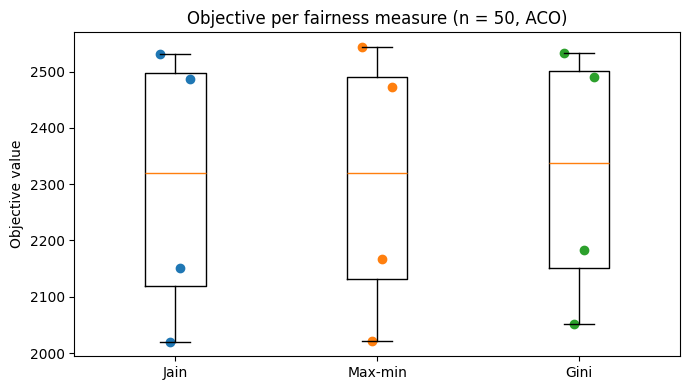

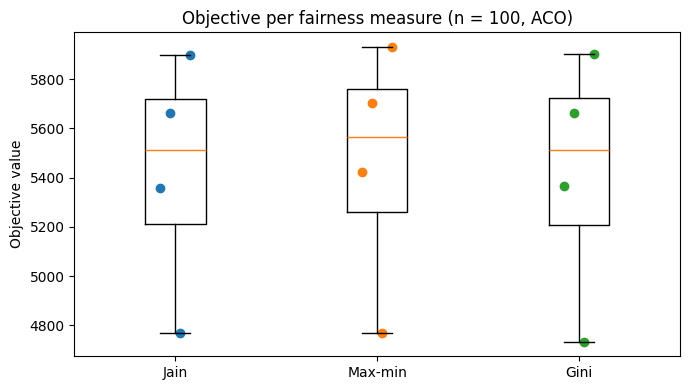

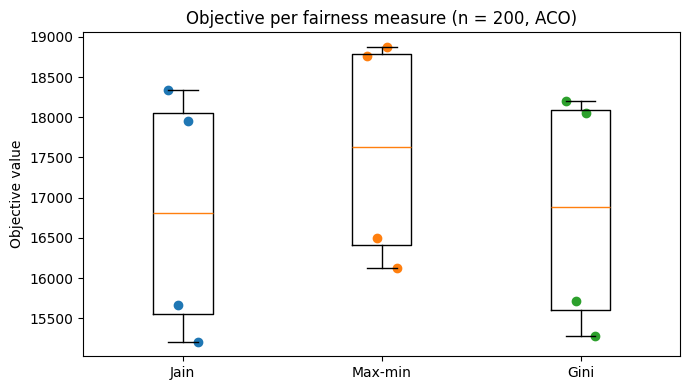

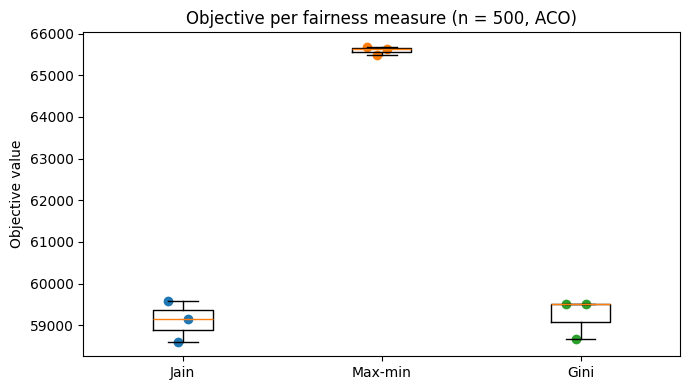

In [51]:
data_aco_50 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}
data_aco_100 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}
data_aco_200 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}
data_aco_500 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}

for n, inst, meas, obj, rt, st in rows_aco:
    if n == 50:
        data_aco_50[meas].append(obj)
    elif n == 100:
        data_aco_100[meas].append(obj)
    elif n == 200:
        data_aco_200[meas].append(obj)
    elif n == 500:
        data_aco_500[meas].append(obj)


# ---- plots ----
plot_fairness_box(data_aco_50,  "Objective per fairness measure (n = 50, ACO)")
plot_fairness_box(data_aco_100, "Objective per fairness measure (n = 100, ACO)")
plot_fairness_box(data_aco_200, "Objective per fairness measure (n = 200, ACO)")
plot_fairness_box(data_aco_500, "Objective per fairness measure (n = 500, ACO)")


### Combined figure

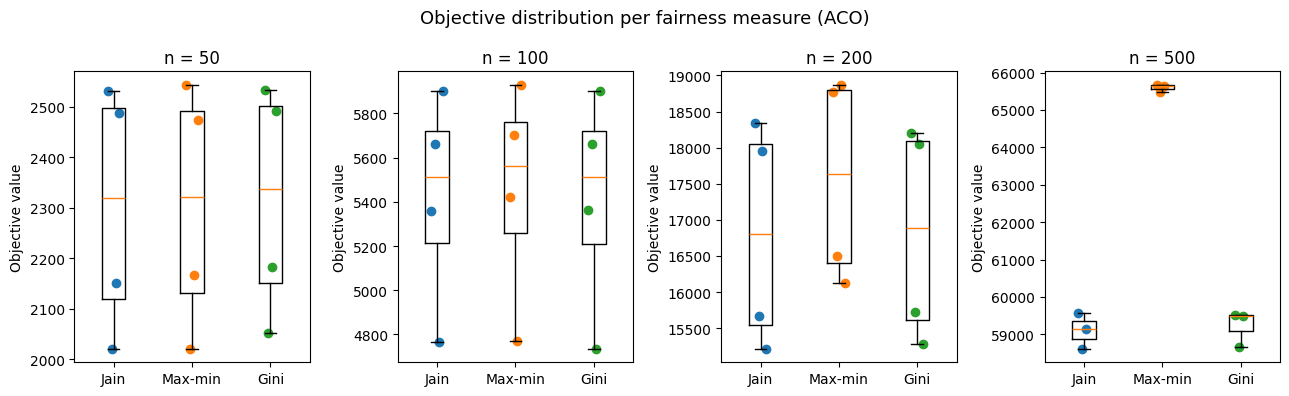

In [52]:
fig, axes = plt.subplots(1, 4, figsize=(13, 4), sharey=False)

plot_subplot(axes[0], data_aco_50,  "n = 50")
plot_subplot(axes[1], data_aco_100, "n = 100")
plot_subplot(axes[2], data_aco_200, "n = 200")
plot_subplot(axes[3], data_aco_500, "n = 500")

fig.suptitle("Objective distribution per fairness measure (ACO)", fontsize=13)
plt.tight_layout()
plt.show()

# Genetic Algorithm

In [53]:
data_gen = []

# Data transcribed from user's LaTeX table (seed=1)
# Format: (n, instance, fairness, obj, route_times, stops)
rows_gen = [
    (50, "instance31_nreq50_gamma50", "Jain", 3119.07, [1641, 1478], [52,48]),
    (50, "instance31_nreq50_gamma50", "Max-min", 3239.88, [1949, 1282], [56,44]),
    (50, "instance31_nreq50_gamma50", "Gini", 3310.27, [1492, 1817], [46,54]),

    (50, "instance32_nreq50_gamma45", "Jain", 2601.85, [994, 1606], [34,56]),
    (50, "instance32_nreq50_gamma45", "Max-min", 2709.58, [1323, 1385], [44,46]),
    (50, "instance32_nreq50_gamma45", "Gini", 2670.52, [1374, 1296], [44,46]),

    (50, "instance33_nreq50_gamma45", "Jain", 2755.01, [1357, 1398], [48,42]),
    (50, "instance33_nreq50_gamma45", "Max-min", 2688.75, [1540, 1138], [52,38]),
    (50, "instance33_nreq50_gamma45", "Gini", 2757.21, [1297, 1459], [42,48]),

    (50, "instance34_nreq50_gamma47", "Jain", 3125.53, [1203, 1919], [38,56]),
    (50, "instance34_nreq50_gamma47", "Max-min", 3129.17, [1577, 1551], [48,46]),
    (50, "instance34_nreq50_gamma47", "Gini", 3109.87, [1723, 1383], [50,44]),

    (100, "instance31_nreq100_gamma86", "Jain", 7817.00, [3931, 3886], [86,86]),
    (100, "instance31_nreq100_gamma86", "Max-min", 7915.78, [3411, 4486], [74,98]),
    (100, "instance31_nreq100_gamma86", "Gini", 8040.38, [3672, 4365], [80,92]),

    (100, "instance36_nreq100_gamma90", "Jain", 7922.64, [4406, 3516], [98,82]),
    (100, "instance36_nreq100_gamma90", "Max-min", 7865.40, [3917, 3948], [88,92]),
    (100, "instance36_nreq100_gamma90", "Gini", 7923.70, [4689, 3230], [98,82]),

    (100, "instance41_nreq100_gamma86", "Jain", 6764.26, [3123, 3641], [74,98]),
    (100, "instance41_nreq100_gamma86", "Max-min", 6649.90, [2806, 3832], [70,102]),
    (100, "instance41_nreq100_gamma86", "Gini", 6873.87, [3147, 3725], [78,94]),

    (100, "instance46_nreq100_gamma92", "Jain", 9257.03, [4490, 4767], [90,94]),
    (100, "instance46_nreq100_gamma92", "Max-min", 9275.67, [4444, 4829], [88,96]),
    (100, "instance46_nreq100_gamma92", "Gini", 8539.47, [4389, 4150], [88,96]),

    (200, "instance31_nreq200_gamma192", "Jain", 28832.34, [8916, 5887, 6071, 7950], [118,82,82,102]),
    (200, "instance31_nreq200_gamma192", "Max-min", 28917.29, [8916, 5887, 6071, 7950], [118,82,82,102]),
    (200, "instance31_nreq200_gamma192", "Gini", 28850.12, [8916, 5887, 6071, 7950], [118,82,82,102]),

    (200, "instance36_nreq200_gamma181", "Jain", 26594.74, [5649, 6961, 7084, 6898], [82,96,92,92]),
    (200, "instance36_nreq200_gamma181", "Max-min", 26665.44, [5649, 6961, 7084, 6898], [82,96,92,92]),
    (200, "instance36_nreq200_gamma181", "Gini", 26606.89, [5649, 6961, 7084, 6898], [82,96,92,92]),

    (200, "instance41_nreq200_gamma196", "Jain", 28605.04, [8117, 7639, 7461, 5381], [106,100,108,78]),
    (200, "instance41_nreq200_gamma196", "Max-min", 28710.66, [8117, 7639, 7461, 5381], [106,100,108,78]),
    (200, "instance41_nreq200_gamma196", "Gini", 28622.50, [8117, 7639, 7461, 5381], [106,100,108,78]),

    (200, "instance46_nreq200_gamma178", "Jain", 26183.44, [7094, 7211, 5588, 6285], [96,96,78,86]),
    (200, "instance46_nreq200_gamma178", "Max-min", 26300.58, [7094, 7211, 5588, 6285], [96,96,78,86]),
    (200, "instance46_nreq200_gamma178", "Gini", 26207.53, [7094, 7211, 5588, 6285], [96,96,78,86]),

    (500, "instance31_nreq500_gamma465", "Jain", 108123.27, [11096, 12128, 10320, 7860, 9810, 13060, 9589, 9605, 11235, 13377], [98, 110, 84, 72, 82, 112, 88, 82, 94, 108]),
    (500, "instance31_nreq500_gamma465", "Max-min", 108883.41, [11096, 12128, 10320, 7860, 9810, 13060, 9589, 9605, 11235, 13377], [98, 110, 84, 72, 82, 112, 88, 82, 94, 108]),
    (500, "instance31_nreq500_gamma465", "Gini", 108245.13, [11096, 12128, 10320, 7860, 9810, 13060, 9589, 9605, 11235, 13377], [98, 110, 84, 72, 82, 112, 88, 82, 94, 108]),

    (500, "instance36_nreq500_gamma472", "Jain", 107380.89, [9573, 12570, 10532, 8276, 9156, 10952, 13265, 9819, 11844, 11349], [84, 110, 92, 74, 82, 88, 116, 88, 104, 106]),
    (500, "instance36_nreq500_gamma472", "Max-min", 108229.28, [9573, 12570, 10532, 8276, 9156, 10952, 13265, 9819, 11844, 11349], [84, 110, 92, 74, 82, 88, 116, 88, 104, 106]),
    (500, "instance36_nreq500_gamma472", "Gini", 107524.45, [9573, 12570, 10532, 8276, 9156, 10952, 13265, 9819, 11844, 11349], [84, 110, 92, 74, 82, 88, 116, 88, 104, 106]),

    (500, "instance41_nreq500_gamma470", "Jain", 108168.04, [10838, 10838, 10101, 10837, 9935, 8767, 14399, 11724, 11052, 9644], [94, 92, 90, 94, 84, 68, 126, 104, 104, 84]),
    (500, "instance41_nreq500_gamma470", "Max-min", 108882.34, [10838, 10838, 10101, 10837, 9935, 8767, 14399, 11724, 11052, 9644], [94, 92, 90, 94, 84, 68, 126, 104, 104, 84]),
    (500, "instance41_nreq500_gamma470", "Gini", 108264.07, [10838, 10838, 10101, 10837, 9935, 8767, 14399, 11724, 11052, 9644], [94, 92, 90, 94, 84, 68, 126, 104, 104, 84]),
]

for n, inst, meas, obj, rt, st in rows_gen:
    data_gen.append({
        "n": n, "instance": inst, "measure": meas, "obj": obj,
        "route_times": rt, "stops": st, "fairness_value": fairness_value(rt, meas)
    })

df_gen = pd.DataFrame(data_gen)
df_gen.head(), df_gen.shape

(    n                   instance  measure      obj   route_times     stops  \
 0  50  instance31_nreq50_gamma50     Jain  3119.07  [1641, 1478]  [52, 48]   
 1  50  instance31_nreq50_gamma50  Max-min  3239.88  [1949, 1282]  [56, 44]   
 2  50  instance31_nreq50_gamma50     Gini  3310.27  [1492, 1817]  [46, 54]   
 3  50  instance32_nreq50_gamma45     Jain  2601.85   [994, 1606]  [34, 56]   
 4  50  instance32_nreq50_gamma45  Max-min  2709.58  [1323, 1385]  [44, 46]   
 
    fairness_value  
 0        0.997276  
 1        0.657773  
 2        0.950892  
 3        0.947503  
 4        0.955235  ,
 (45, 7))

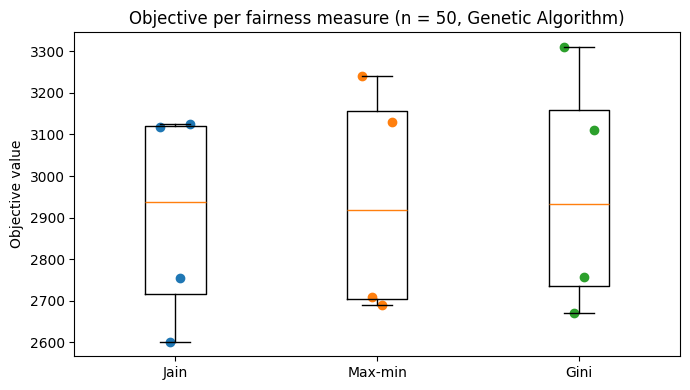

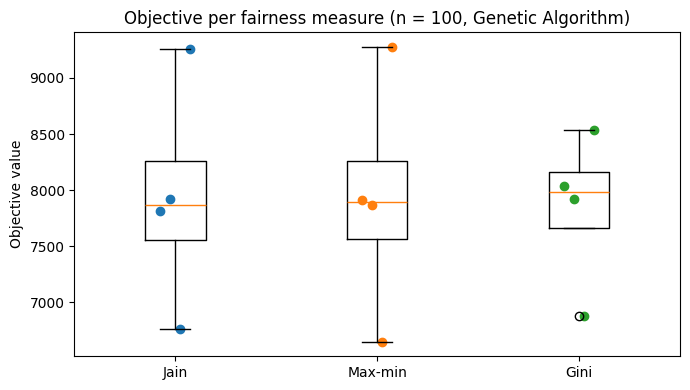

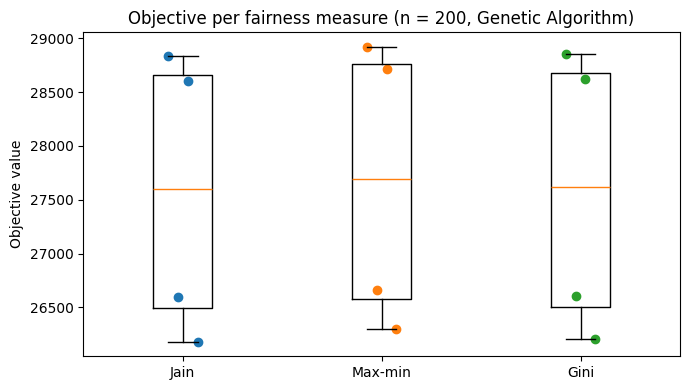

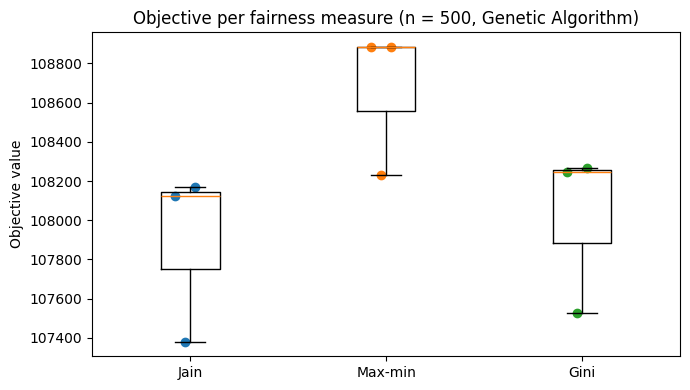

In [57]:
data_gen_50 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}
data_gen_100 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}
data_gen_200 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}
data_gen_500 = {
    "Jain":    [],
    "Max-min": [],
    "Gini":    [],
}

for n, inst, meas, obj, rt, st in rows_gen:
    if n == 50:
        data_gen_50[meas].append(obj)
    elif n == 100:
        data_gen_100[meas].append(obj)
    elif n == 200:
        data_gen_200[meas].append(obj)
    elif n == 500:
        data_gen_500[meas].append(obj)


# ---- plots ----
plot_fairness_box(data_gen_50,  "Objective per fairness measure (n = 50, Genetic Algorithm)")
plot_fairness_box(data_gen_100, "Objective per fairness measure (n = 100, Genetic Algorithm)")
plot_fairness_box(data_gen_200, "Objective per fairness measure (n = 200, Genetic Algorithm)")
plot_fairness_box(data_gen_500, "Objective per fairness measure (n = 500, Genetic Algorithm)")


### Combined figure

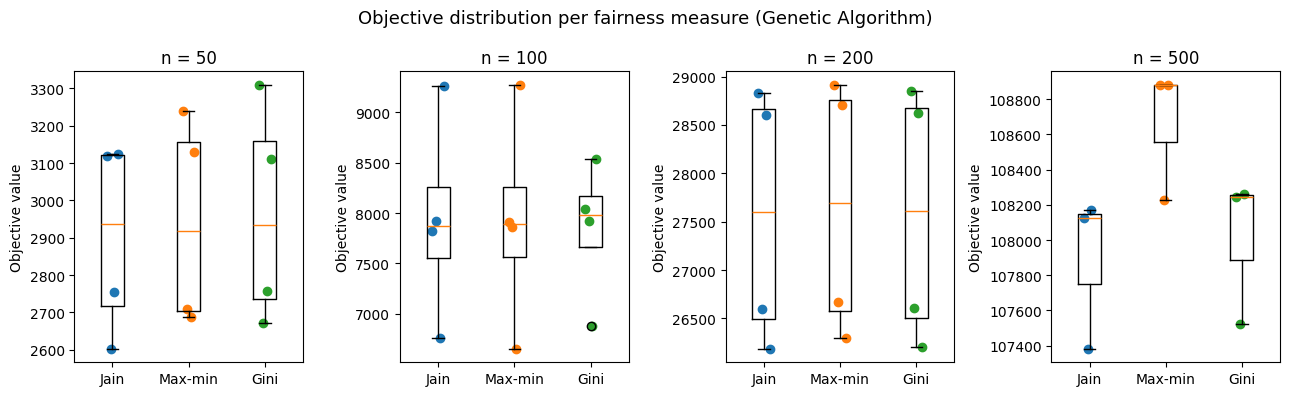

In [58]:
fig, axes = plt.subplots(1, 4, figsize=(13, 4), sharey=False)

plot_subplot(axes[0], data_gen_50,  "n = 50")
plot_subplot(axes[1], data_gen_100, "n = 100")
plot_subplot(axes[2], data_gen_200, "n = 200")
plot_subplot(axes[3], data_gen_500, "n = 500")

fig.suptitle("Objective distribution per fairness measure (Genetic Algorithm)", fontsize=13)
plt.tight_layout()
plt.show()